In [1]:
import numpy as np
import matplotlib.pyplot as plt
from classy import Class  
import math
from numpy.linalg import inv
from IPython.display import Image

In [2]:
f_sky = 0.65
n_power = 0
dm_mass = 1 #GeV
step_size_cross_section = 2e-26 * pow(dm_mass,0.15)
Tcmb = 2.7255 #2.726
l_min = 2
l_max = 2500

list_param = ['omega_b','omega_cdm', 'h',  'A_s', 'n_s', 'tau_reio','sigma_dmb']
list_fiducial = [0.0224, 0.12, 0.6730804,  2.2e-9, 0.96, 0.07, 0.0]
list_step = [0.0001,     0.001,    0.004,   0.01e-9, 0.005, 0.02, step_size_cross_section]
list_param_step = list(zip(list_param, list_step))

#2e-26 * pow(dm_mass,0.15) <- n=0 
#4e-19 * pow(dm_mass,0.70) <- n=2 for 1e-5 and 1e-4: 4e-19 * pow(dm_mass,1.2)
#6e-13 * pow(dm_mass,1.25) <- n=4 
#8e-7 * pow(dm_mass,1.3)   <- n=6 
#3e-34 * pow(dm_mass,0.5)  <- n=-2

import time
start_time = time.time()
from datetime import datetime
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Starting Time =", current_time)

Starting Time = 07:55:39


In [3]:
# Define the CLASS input dictionary, use defaults
params = {
    'output': 'tCl pCl lCl,','l_max_scalars': 2500,
    'omega_b': list_fiducial[0],'omega_dmb': list_fiducial[1],'h': list_fiducial[2],'A_s' : list_fiducial[3],'n_s' : list_fiducial[4], 'tau_reio' : list_fiducial[5],'sigma_dmb': list_fiducial[6],
    'm_dmb': dm_mass,
    'omega_cdm' : 1.0e-22,
    'n_dmb': n_power,
    'N_ur': 2.0328,
    'N_ncdm': 1,
    'm_ncdm': 0.06,
    'T_ncdm':0.71611,
    'reionization_optical_depth_tol': 1e-07,
    'perturb_sampling_stepsize':0.01,
    'k_max_tau0_over_l_max' : 6,
    'gauge' : 'synchronous'
}

# The usual CLASS code for computing C_l - fiducial only:
cosmo = Class()
cosmo.set(params)
cosmo.compute()
fiducial = cosmo.raw_cl(2500)
cosmo.struct_cleanup()
cosmo.empty()
ell = fiducial['ell']

Cl_est_kk = []
for i in ell:
    if i < 2:
        Cl_est_kk.append(0)
    else:
        Cl_est_kk.append(1/4*(math.factorial(i+2)/math.factorial(i-2))*fiducial['pp'][i]/(1.0e6*Tcmb)**2) #unitless
        
Cl_kk = []
for i in ell:
    if i < 2:
        Cl_kk.append(0)
    else:
        Cl_kk.append(1/4*(math.factorial(i+2)/math.factorial(i-2))*fiducial['pp'][i]) #uK^2    
        

In [4]:
#reading each line from file and replacing "-" by ","
data = np.loadtxt("noise/planck_noise_k_fishchips.txt", delimiter = " ")
N_KK = data[:,3]
N_TT_fishchips = data[:,1] #in units of uK^2
N_EE_fishchips = data[:,2]

plancknoise = np.load('noise/Planck_noise.npy')
nl_tt_planck = plancknoise[0]  #in units of uK^2
nl_ee_planck = plancknoise[1]
nl_kk_planck = plancknoise[2]

Nl_tt = nl_tt_planck /((1.0e6*Tcmb)**2) #unit less - using these in fisher matrix
Nl_ee = nl_ee_planck #/((1.0e6*Tcmb)**2)
Nl_kk = nl_kk_planck #/((1.0e6*Tcmb)**2)

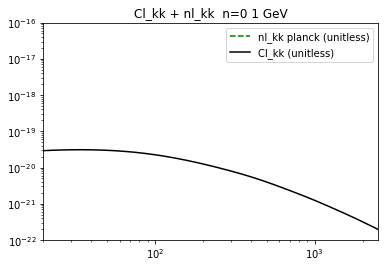

In [5]:
plt.plot(Nl_kk , 'g--',label="nl_kk planck (unitless)")
plt.plot(Cl_est_kk, 'k-',label="Cl_kk (unitless)")
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-22,1e-16)
plt.xlim(20,2500)
plt.legend(loc="upper right")
plt.title('Cl_kk + nl_kk  n=0 1 GeV')
plt.show()

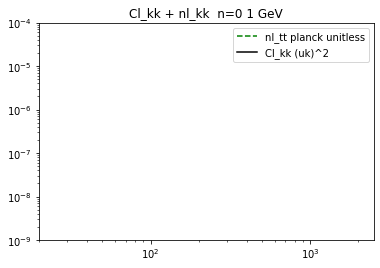

In [6]:
plt.plot(Nl_tt , 'g--',label="nl_tt planck unitless")
plt.plot(fiducial['tt'], 'k-',label="Cl_kk (uk)^2")
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-9,1e-4)
plt.xlim(20,2500)
plt.legend(loc="upper right")
plt.title('Cl_kk + nl_kk  n=0 1 GeV')
plt.show()

In [7]:
'''sT = (33. * (np.pi/60./180. ))/(1.0e6*Tcmb) #Unitless to match fiducal Cl's
sP = (56. * (np.pi/60./180. ))/(1.0e6*Tcmb) #Unitless to match fiducal Cl's
f_sky = 0.65
theta_fwhm = 7. * (np.pi/60./180.)

l_min = 2
l_max = 2500

from scipy.special import expit

N_TT = np.zeros(l_max+1, 'float64')
N_EE = np.zeros(l_max+1, 'float64')

for l in range(l_min , l_max+1):
            N_TT[l] = 0
            N_TT[l] += sT**-2 *\
                    np.exp(
                        -l*(l+1)*theta_fwhm**2/8./np.log(2.))
            N_TT[l] = 1/N_TT[l]
            N_EE[l] = 0
            N_EE[l] += sP**-2 *\
                    np.exp(
                        -l*(l+1)*theta_fwhm**2/8./np.log(2.))
            N_EE[l] = 1/N_EE[l]
N_TT[ell < l_min] = 1e100
N_TT[ell > l_max] = 1e100
N_EE[ell < l_min] = 1e100
N_EE[ell > l_max] = 1e100'''

"sT = (33. * (np.pi/60./180. ))/(1.0e6*Tcmb) #Unitless to match fiducal Cl's\nsP = (56. * (np.pi/60./180. ))/(1.0e6*Tcmb) #Unitless to match fiducal Cl's\nf_sky = 0.65\ntheta_fwhm = 7. * (np.pi/60./180.)\n\nl_min = 2\nl_max = 2500\n\nfrom scipy.special import expit\n\nN_TT = np.zeros(l_max+1, 'float64')\nN_EE = np.zeros(l_max+1, 'float64')\n\nfor l in range(l_min , l_max+1):\n            N_TT[l] = 0\n            N_TT[l] += sT**-2 *                    np.exp(\n                        -l*(l+1)*theta_fwhm**2/8./np.log(2.))\n            N_TT[l] = 1/N_TT[l]\n            N_EE[l] = 0\n            N_EE[l] += sP**-2 *                    np.exp(\n                        -l*(l+1)*theta_fwhm**2/8./np.log(2.))\n            N_EE[l] = 1/N_EE[l]\nN_TT[ell < l_min] = 1e100\nN_TT[ell > l_max] = 1e100\nN_EE[ell < l_min] = 1e100\nN_EE[ell > l_max] = 1e100"

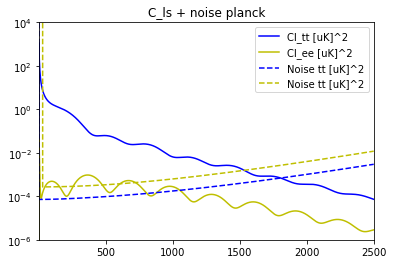

In [8]:
Cl_tt = fiducial['tt']* (2.72*1e6)**2
Cl_ee = fiducial['ee']* (2.72*1e6)**2

plt.plot(Cl_tt, 'b-',label="Cl_tt [uK]^2")
plt.plot(Cl_ee, 'y-',label="Cl_ee [uK]^2")
plt.plot(nl_tt_planck, 'b--',label="Noise tt [uK]^2")
plt.plot(nl_ee_planck, 'y--',label="Noise tt [uK]^2")

plt.yscale('log')
plt.ylim(1e-6,1e4)
plt.xlim(2,2500)
plt.legend(loc="upper right")
plt.title('C_ls + noise planck')
#plt.savefig("C_l_compare_n_0_1GeV_planck.png")
plt.show()

In [9]:
#For right and left C_l's:
def utility_function_call_CLASS(input_dict, l_max=2500):
    """Compute Cl with this utility function, repeat less code."""
    cosmo = Class()
    cosmo.set(input_dict)
    cosmo.compute()
    temp_cl = cosmo.raw_cl(l_max)
    cosmo.struct_cleanup()
    cosmo.empty()
    return temp_cl

In [10]:
def compute_derivative(params, theta, XY, stepsize, fiduc):
    left_params = params.copy()
    if theta == 'sigma_dmb':
        left_params[theta] = params[theta]
        right_params = params.copy()
        right_params[theta] = params[theta] + stepsize

        # get the C_l^XY and then compute the derivative!
        cl_XY_left = utility_function_call_CLASS(left_params)[XY]
        cl_XY_right = utility_function_call_CLASS(right_params)[XY]
        dClXY_dparam = (cl_XY_right - cl_XY_left) / (stepsize)
    else:
        left_params[theta] = params[theta] - stepsize
        right_params = params.copy()
        right_params[theta] = params[theta] + stepsize

        # get the C_l^XY and then compute the derivative!
        cl_XY_left = utility_function_call_CLASS(left_params)[XY]
        cl_XY_right = utility_function_call_CLASS(right_params)[XY]
        dClXY_dparam = (cl_XY_right - cl_XY_left) / (2 * stepsize)

    return dClXY_dparam / fiduc[XY], dClXY_dparam

def compute_d_cl(list_param_step, params, XY, fiducial):
    der_map = {}
    d_cl = {}
    for (par, stepsize) in list_param_step:
        norm_derivative, derivative = compute_derivative(params, par, XY, stepsize, fiducial)
        der_map[par] = norm_derivative
        d_cl[par] = derivative
    return d_cl

def compute_d_cl_der_map(list_param_step, params, XY, fiducial):
    der_map = {}
    d_cl = {}
    for (par, stepsize) in list_param_step:
        norm_derivative, derivative = compute_derivative(params, par, XY, stepsize, fiducial)
        der_map[par] = norm_derivative
        d_cl[par] = derivative
    return d_cl, der_map

<ipython-input-10-7f0aee16fb63>:22: RuntimeWarning: invalid value encountered in true_divide
  return dClXY_dparam / fiduc[XY], dClXY_dparam


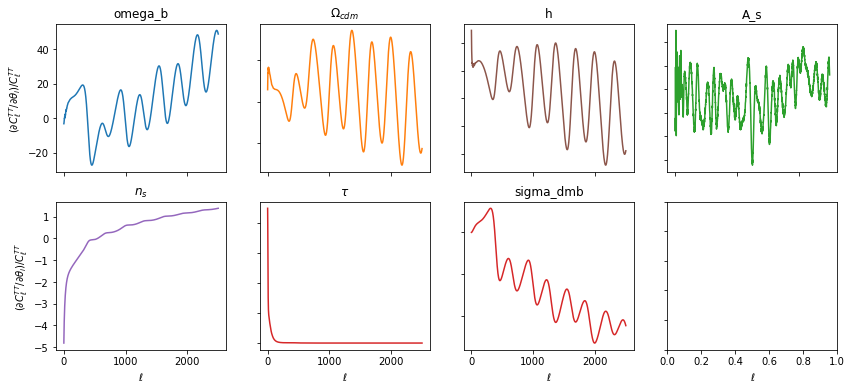

In [11]:
#Plotting Derivatives
dict_params, dict_norm_der = compute_d_cl_der_map(list_param_step, params, 'tt', fiducial)
fig, axs = plt.subplots(2, 4, figsize=(14,6))
axs[0, 0].plot(dict_norm_der['omega_b'])
axs[0, 0].set_title('omega_b')
axs[0, 1].plot(dict_norm_der['omega_cdm'], 'tab:orange')
axs[0, 1].set_title(r'$\Omega_{cdm}$')
axs[0, 2].plot(dict_norm_der['h'], 'tab:brown')
axs[0, 2].set_title('h')
axs[0, 3].plot(dict_norm_der['A_s'], 'tab:green')
axs[0, 3].set_title('A_s')
axs[1, 0].plot(dict_norm_der['n_s'], 'tab:purple')
axs[1, 0].set_title(r'$n_s$')
axs[1, 1].plot(dict_norm_der['tau_reio'], 'tab:red')
axs[1, 1].set_title(r'$\tau$')
axs[1, 2].plot(dict_norm_der['sigma_dmb'], 'tab:red')
axs[1, 2].set_title('sigma_dmb')
for ax in axs.flat:
    ax.set(xlabel=r'$\ell$', ylabel=r'$(\partial C_{\ell}^{TT} / \partial \theta_i) / C_{\ell}^{TT}$')
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer() 
fig.savefig("fisher_plots/derivative_C_l_TT_{}GeV_n={}_planck.png".format(str(dm_mass),str(n_power)))


In [12]:
dC_lpp = compute_d_cl(list_param_step, params, 'pp', fiducial)

def factorial(n):
    fact = 1
    for i in range(1,n+1): 
        fact = fact * i 
    return fact

dC_lkk = {}
for k, array in dC_lpp.items():
    list_a = []
    for l, a in enumerate(array):
        if l < 2:
            list_a.append(0)
        else:
            list_a.append(1.0/4 * (factorial(l+2)/factorial(l-2)) * a)        
    dC_lkk[k] = np.array(list_a)
    
#print(dC_lkk)

<ipython-input-10-7f0aee16fb63>:22: RuntimeWarning: invalid value encountered in true_divide
  return dClXY_dparam / fiduc[XY], dClXY_dparam


In [13]:
#unitless for all Cl's and N's:
MAT_d_cl = [[compute_d_cl(list_param_step, params, 'tt', fiducial), compute_d_cl(list_param_step, params, 'te', fiducial), 0],
            [compute_d_cl(list_param_step, params, 'te', fiducial), compute_d_cl(list_param_step, params, 'ee', fiducial), 0],
            [0, 0, dC_lkk]]
    
MAT_cl = [ [fiducial['tt'] + Nl_tt, fiducial['te'], 0], 
           [fiducial['te'], fiducial['ee'] + Nl_ee, 0],
           [0, 0, Cl_est_kk + Nl_kk] ]

<ipython-input-10-7f0aee16fb63>:22: RuntimeWarning: invalid value encountered in true_divide
  return dClXY_dparam / fiduc[XY], dClXY_dparam


In [14]:
#for i in list_param:
def compute_Q_i(i, l):
    d_Cl_i = [[MAT_d_cl[0][0][i][l], MAT_d_cl[0][1][i][l], 0], 
              [MAT_d_cl[1][0][i][l], MAT_d_cl[1][1][i][l], 0],
              [0, 0, MAT_d_cl[2][2][i][l]]]

    cl = [[MAT_cl[0][0][l], MAT_cl[0][1][l], 0],
          [MAT_cl[1][0][l], MAT_cl[1][1][l], 0],
          [0, 0, MAT_cl[2][2][l]]]
    Q_i = np.matmul(inv(cl), d_Cl_i)
    return Q_i

def compute_F_ij(i, j):
    F_ij = 0
    for l in range(2, 2500):
        F_ij += 0.5*(2*l + 1) *f_sky * np.trace(np.matmul(compute_Q_i(i, l), compute_Q_i(j, l)))
    return F_ij

In [15]:
f_sky = 0.65

In [16]:
F =[]
for x in list_param:
    row = []
    for y in list_param:
        row.append(compute_F_ij(x, y))
    F.append(row)

In [17]:
covar = inv(F)
for n, i in enumerate(list_param):
    sigma_ii = np.sqrt(covar[n][n])
    print(i, sigma_ii)

omega_b 0.00017701500200470915
omega_cdm 0.0020882473618687044
h 0.009034379763371427
A_s 9.089483668932057e-11
n_s 0.009177640851840195
tau_reio 0.021692826226933252
sigma_dmb 1.261378770875276e-25


generating new axis
['omega_b', 'omega_cdm', 'h', 'A_s', 'n_s', 'tau_reio', 'sigma_dmb']


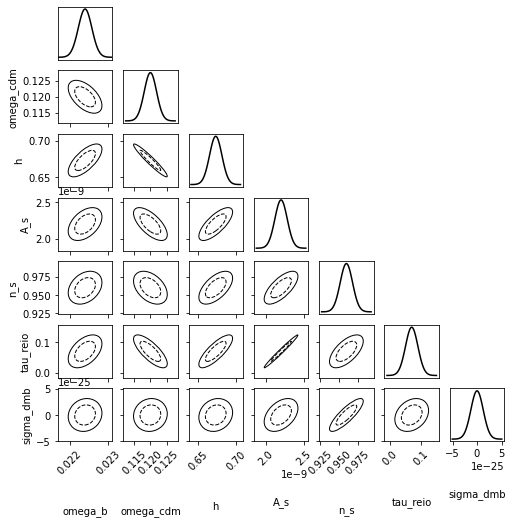

In [18]:
import fishchips.util

cov = np.linalg.inv(F)
fig, axes = fishchips.util.plot_triangle_base(list_param, list_fiducial, covar, labels=list_param);

fig.savefig("fisher_plots/triagular_ellipses_{}GeV_n={}_planck.png".format(str(dm_mass),str(n_power)))

In [19]:
dat = ('n-power=',n_power,'dm_mass=', dm_mass, 'stepsize =', step_size_cross_section,'fisher matrix =', F,i, "from cov matrix =",sigma_ii,"2-sigma =")


In [20]:
print(dat)

('n-power=', 0, 'dm_mass=', 1, 'stepsize =', 2e-26, 'fisher matrix =', [[177678987.46359965, -47175075.293268055, -12784556.928236222, 1751695245965984.2, 3779002.8029602864, -7721536.892834339, -2.285507158036534e+29], [-47175075.293268055, 23563740.66567615, 5127723.27510991, -1309933733225654.0, -1600175.5478045533, 5791027.941981289, 1.4291510681818142e+29], [-12784556.928236222, 5127723.27510991, 1270521.5659474828, -214314202178719.34, -365211.2426613384, 941101.1052717944, 2.469798798530511e+28], [1751695245965984.2, -1309933733225654.0, -214314202178719.34, 1.7569508992324307e+23, 213828999566759.2, -771098569783750.2, -2.5882027840038245e+37], [3779002.8029602864, -1600175.5478045533, -365211.2426613384, 213828999566759.2, 453390.66014471574, -944367.9565451219, -4.216908696175652e+28], [-7721536.892834339, 5791027.941981289, 941101.1052717944, -771098569783750.2, -944367.9565451219, 3390897.026299709, 1.1359313269161075e+29], [-2.285507158036534e+29, 1.4291510681818142e+29, 2

In [21]:
outF = open("fisher_data/planck_n={}/{}GeV.txt".format(str(n_power),str(dm_mass)), "w")
for i in dat:
  # write line to output file
  outF.write(str(i))
  outF.write("\n")
outF.close()